In [11]:
%%time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


CPU times: user 825 ms, sys: 983 ms, total: 1.81 s
Wall time: 3.76 s


In [12]:
%%time
# 셔플, 미니배치, 프리페치 파이프라인 코드 삽입 및 batch_size = 512 로 증가
batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

CPU times: user 1.54 s, sys: 2.78 s, total: 4.32 s
Wall time: 4.33 s


In [13]:
%%time
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 13.6 µs


In [14]:
%%time
model = ResNet18()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 64)   256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 32, 32, 64)   0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [15]:
%%time
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

CPU times: user 6.38 ms, sys: 1.93 ms, total: 8.31 ms
Wall time: 6.57 ms


In [16]:
%%time
# 학습 루프
history = model.fit(train_dataset, batch_size=batch_size, epochs=100)
test_loss, test_acc = model.evaluate(x_test, y_test)

# 모델 평가
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Epoch 1/100
98/98 [==============================] - 50s 444ms/step - loss: 1.4839 - accuracy: 0.4783
Epoch 2/100
98/98 [==============================] - 41s 414ms/step - loss: 0.9097 - accuracy: 0.6757
Epoch 3/100
98/98 [==============================] - 40s 412ms/step - loss: 0.6652 - accuracy: 0.7668
Epoch 4/100
98/98 [==============================] - 41s 413ms/step - loss: 0.5000 - accuracy: 0.8255
Epoch 5/100
98/98 [==============================] - 40s 412ms/step - loss: 0.3838 - accuracy: 0.8632
Epoch 6/100
98/98 [==============================] - 41s 413ms/step - loss: 0.2863 - accuracy: 0.9009
Epoch 7/100
98/98 [==============================] - 41s 413ms/step - loss: 0.1948 - accuracy: 0.9313
Epoch 8/100
98/98 [==============================] - 41s 413ms/step - loss: 0.1517 - accuracy: 0.9463
Epoch 9/100
98/98 [==============================] - 41s 413ms/step - loss: 0.1097 - accuracy: 0.9610
Epoch 10/100
98/98 [==============================] - 41s 413ms/step - loss: 0.087

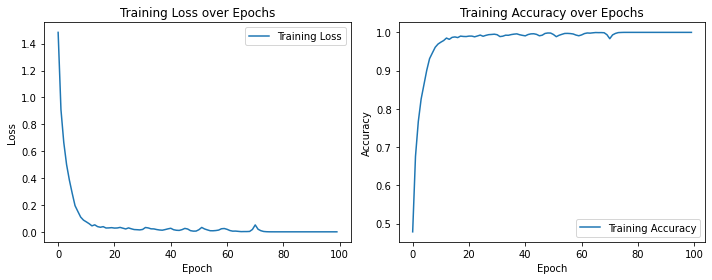

CPU times: user 533 ms, sys: 254 ms, total: 787 ms
Wall time: 381 ms


In [17]:
%%time
# 학습 결과 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

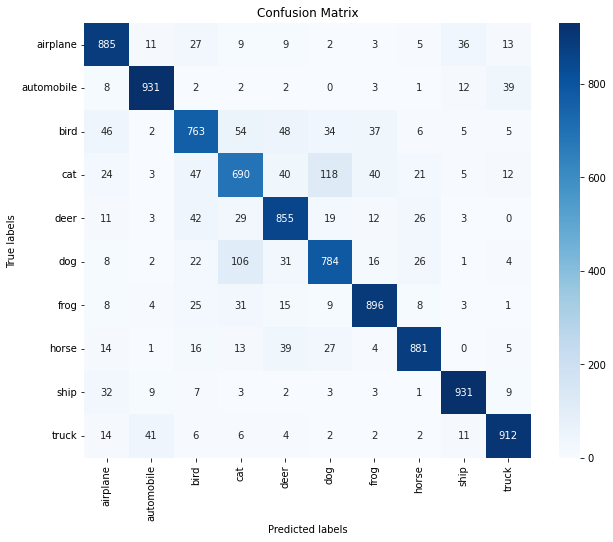

In [18]:
# 상관관계 분석
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 모델을 사용하여 예측 수행
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

# 컨퓨전 매트릭스 생성
cm = confusion_matrix(y_true, y_pred_classes)

# 컨퓨전 매트릭스 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

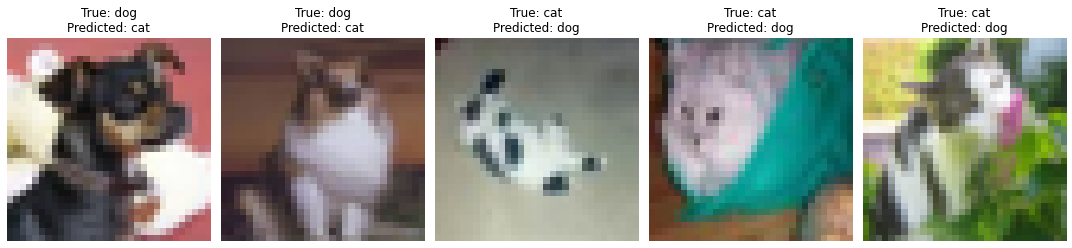

In [19]:
# 모델 예측
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.squeeze()


misclassified_as_dog = np.where((y_true == 3) & (y_pred_classes == 5))[0]
misclassified_as_cat = np.where((y_true == 5) & (y_pred_classes == 3))[0]


total_misclassified = np.concatenate([misclassified_as_dog, misclassified_as_cat])


selected_idx = np.random.choice(total_misclassified, 5, replace=False)

# 시각화
plt.figure(figsize=(15, 5))

for i, idx in enumerate(selected_idx):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"True: {class_names[y_true[idx]]}\nPredicted: {class_names[y_pred_classes[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

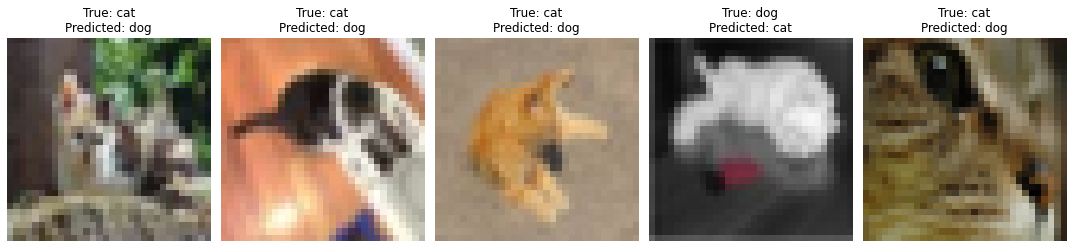

In [20]:
selected_idx = np.random.choice(total_misclassified, 5, replace=False)

# 시각화
plt.figure(figsize=(15, 5))

for i, idx in enumerate(selected_idx):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[idx], cmap='gray')  
    plt.title(f"True: {class_names[y_true[idx]]}\nPredicted: {class_names[y_pred_classes[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# batch_size = 512 로 증가
# 에폭 100회 연산 시간 : 1: 09 : 22
# Train acc : 1.00
# Test acc : 0.85
# Test loss : 0.9582
# Test02의 평균 에폭 시간이 44초 였는데 평균 에폭 시간이 40초로 감소
# batch_size를 늘릴 수록 연산시간이 감소하는 과정을 확인. 또한 그에 비해 Train, test acc 의 값이 떨어지지 않는 점을 확인 하였음.
# 다만 그러면 셔플,미니배치 등의 파이프라인 작업이 유의미한 성과를 나타내는지가 불분명한 모습으로 관찰됨
# Test04에서는 Baseline에서 batch_size 만 늘리고, 파이프라인 작업은 실행하지 않은채로 얼마나 연산속도가 감소하는지 관찰 예정